使用经典的**SARIMAX**模型, 借助数据, 详细描述整个时间序列(Time Series)建模的过程. 最后的结果并不是很好, 但关键还是在过程中的各个步骤上.

我们对一个具有季节性的数据, 考虑其季节性进行建模. 并使用**外部变量(exog)**对建模进行辅助.

## 读入数据

使用的数据是经典的**[AirPassengers](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv) Dataset**. 首先我们读入数据.

In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams

In [2]:
%matplotlib inline

In [3]:
rcParams["figure.figsize"] = (15, 6)

In [4]:
data = pd.read_csv("AirPassengers.csv", index_col="Month", date_parser=lambda x: pd.datetime.strptime(x, "%Y-%m"))
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
ts = data["#Passengers"]
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

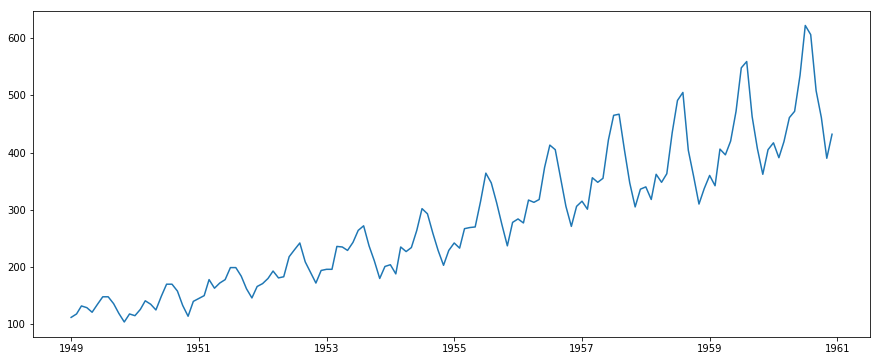

In [6]:
plt.plot(ts)

## 检查加法模型/乘法模型

In [7]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
add_results = seasonal_decompose(ts, model="additive", freq=12)
mul_results = seasonal_decompose(ts, model="multipliative", freq=12)

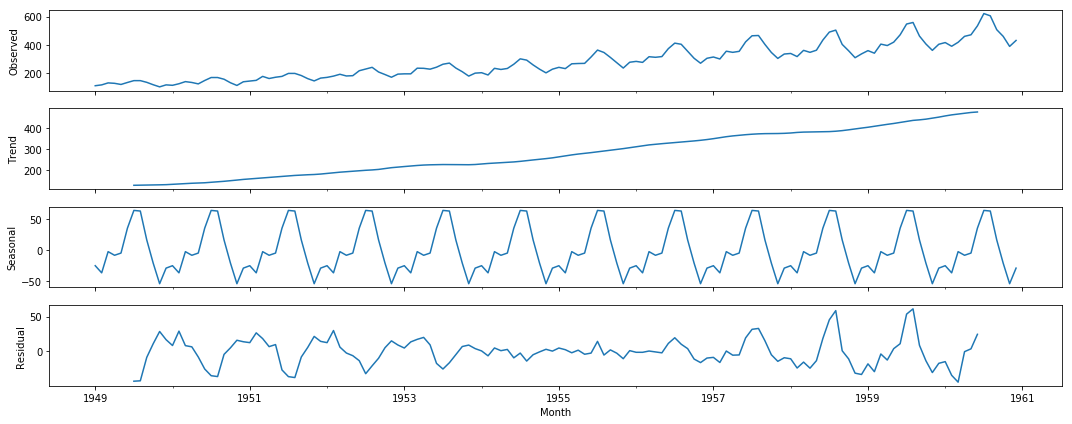

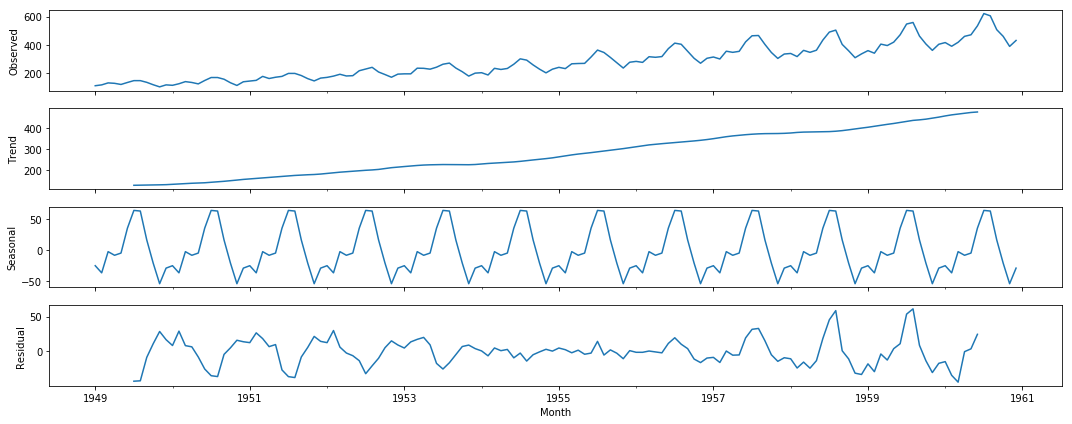

In [9]:
add_results.plot()

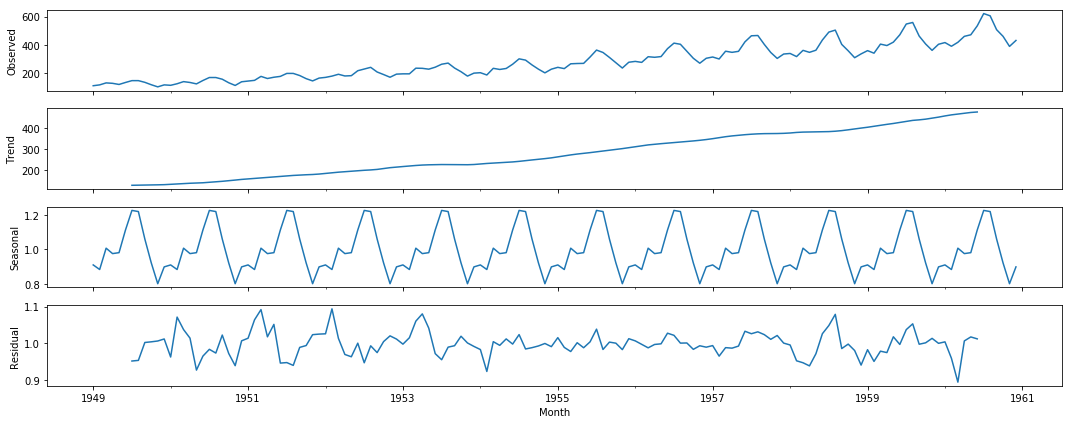

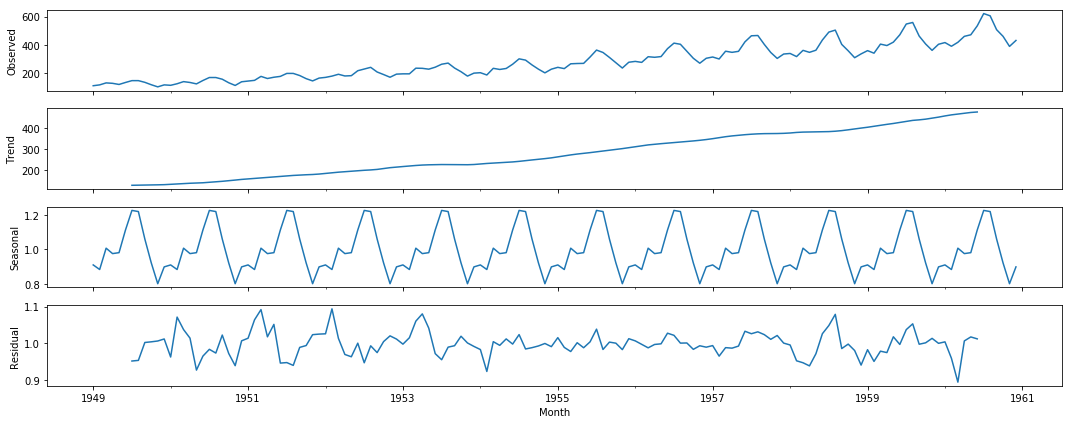

In [10]:
mul_results.plot()

对分解后的**残差**继续进行分析:
- 对残差序列计算**ACF**
- 我们认为, 如果分解后的残差更接近**白噪声序列**, 说明原时间序列**更符合**这种模型. 这是因为白噪声没有**自相关性**, 用**ACF**这种工具来进行评价
- 对ACF值进行**平方**处理, 这一步的目的是去除ACF值的符号的影响
- 对所有`lag`对应的ACF值经过上述计算后**相加**, 然后进行比较, **值更小**的模型更符合当前时间序列

In [11]:
add_resid = add_results.resid.dropna()
mul_resid = mul_results.resid.dropna()
add_acf_total = np.sum(np.square(acf(add_resid)))
mul_acf_total = np.sum(np.square(acf(mul_resid)))
add_acf_total, mul_acf_total, add_acf_total < mul_acf_total

(4.798252313843875, 2.1837168462124206, False)

可以看到, 当前的时间序列更符合**乘法模型**. 因此我们继续围绕乘法模型进行处理和建模.

## 乘法模型的转换

如果时间序列是乘法模型, 需要使用$\log$函数对序列进行转换, 转换之后就成为了加法模型. 然后继续分析, 建模.

需要注意的是, 如果使用$\log$对原时间序列进行了转换, 在最后, 需要将拟合和预测得到的序列使用$\log$函数的反函数, 即**指数函数**进行**还原**.

In [12]:
ts[ts == 0] = 1
ts_log = np.log(ts)
ts_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64

## 划分训练开发集

In [13]:
N = len(ts)
DEV_SIZE = 12
FCST_SIZE = 24
TRAIN_SIZE = N - DEV_SIZE
TRAIN_SIZE, DEV_SIZE, FCST_SIZE, N

(132, 12, 24, 144)

In [14]:
train_ts = ts_log[:-DEV_SIZE]
dev_ts = ts_log[-DEV_SIZE:]
train_ts.shape, dev_ts.shape

((132,), (12,))

## 处理外部变量

外部变量, 根据是否有提供特征序列, 分为有无两种情况.

- 有额外的特征序列

    - 有单个或多个特征, 每个特征也是一个序列, 原时间序列中的每个点都对应着一组特征(长度为特征的数量). 因此时间序列与特征序列的长度是相等的
    
    - 但这些特征并不是外部变量, 而是使用这些特征与原时间序列建模拟合, 预测得到的历史值和未来值组成的时间序列, 才是外部变量
- 没有额外的特征序列
    
    外部变量的核心就是使用拟合时间序列得到的预测序列作为外部变量. 因此, 只要有生成这种拟合序列的方法即可使用外部变量这种方法
    
    - 使用简单的**时间索引**, 即$(1,2,\cdots,N)$作为类似于上面的特征序列
        - 使用**LOWESS**或其他的**线性模型**, 拟合**时间索引**和**时间序列**, 得到训练好的模型. 使用这个模型给出历史和未来的预测值, 组成的新的序列就是最后的外部变量
    
    - 使用**Weighted moving average**对原时间序列进行平滑, 除了得到历史上的平滑结果, 还要使用这种平滑方法对未来序列进行推测, 然后将两者拼接起来, 作为最后的外部变量

需要注意的是, **ARIMAX**, **SARIMAX**模型并不会对外部变量进行预测, 因此就需要我们为模型提供外部变量的未来值, 才能使用这种模型对时间序列的未来进行预测. 这就要求我们在拟合模型之前, 首先使用其他的方法对外部变量进行拟合和预测.

由于需要对外部变量进行额外的建模, 对未来进行需要, 就涉及到在建模时对这个模型进行好坏的评价, 因此就需要使用**开发集**DEV.

In [15]:
train_time_index = np.arange(1, train_ts.shape[0] + 1)
dev_time_index = np.arange(train_ts.shape[0] + 1, train_ts.shape[0] + 1 + DEV_SIZE)
test_time_index = np.arange(train_ts.shape[0] + 1 + DEV_SIZE, train_ts.shape[0] + 1 + DEV_SIZE + FCST_SIZE)
train_dev_test_time_index = np.hstack([train_time_index, dev_time_index, test_time_index])
train_dev_test_time_index.shape

(168,)

### 外部变量: 没有额外的特征序列

此时的核心思想是: 使用**时间索引**对原时间序列进行拟合建模, 并使用拟合好的模型, 对历史和未来进行预测, 使用这个新的序列作为外部变量.

In [16]:
train_x = train_time_index
train_dev_x = np.hstack([train_time_index, dev_time_index])
train_y = train_ts.values
train_dev_y = ts_log.values

#### LOWESS + Linear regression

**Locally Weighted Scatterplot Smoothing + Linear Regression**, 具体方法为:

- 使用简单的时间序列索引作为x, 原时间序列作为y
- 使用LOWESS算法进行拟合, 输出对历史的拟合值, 作为外部变量的历史部分
    - LOWESS算法是**局部的线性拟合**, 更适应于时间序列拟合这种场景
    - 对于`dev`和`test`, 需要使用线性回归模型得到, 即使用时间索引x和LOWESS算法得到的拟合值作为y, 拟合一个**线性回归**模型, 然后用`dev`和`test`对应的时间索引, 预测得到未来的值, 作为外部变量的未来值部分

In [17]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [18]:
lowess_res = sm.nonparametric.lowess(endog=train_y, exog=train_x, frac=0.3)
lowess_res[:5, :]

array([[1.        , 4.7808277 ],
       [2.        , 4.7904466 ],
       [3.        , 4.8001676 ],
       [4.        , 4.81000816],
       [5.        , 4.81998119]])

In [19]:
lowess_y = lowess_res[:, -1]

In [20]:
def lr_predict(tx, ty, px):
    model = LinearRegression()
    model.fit(tx, ty)
    return model.predict(px)

In [21]:
dev_test_pred_y = lr_predict(train_x[:, None], lowess_y, np.hstack([dev_time_index, test_time_index])[:, None])
train_dev_test_exog1 = np.hstack([lowess_y, dev_test_pred_y])
train_dev_test_exog1.shape, dev_test_pred_y.shape

((168,), (36,))

#### Robust Linear Regression

使用**鲁棒性**的线性模型对时间索引和原时间序列进行拟合, 并使用未来的时间索引, 预测未来的值, 作为外部变量.

需要注意的是, 因为用来`dev`和`test`的外部变量是通过拟合的模型预测得到的, 那么外部变量的`train`(历史部分)也就不能使用原始的时间序列, 也要使用模型预测的历史时间点上的值作为外部变量的`train`部分.

In [22]:
from sklearn.linear_model import RANSACRegressor

In [23]:
SEED = 2018

In [24]:
exog_list1 = []

for _ in range(100):
    model_ransac = RANSACRegressor(LinearRegression(), max_trials=10000, random_state=SEED)
    model_ransac.fit(train_x[:, None], train_y)
    exog_list1.append(model_ransac.predict(train_dev_test_time_index[:, None]))

train_dev_test_exog2 = np.mean(exog_list1, axis=0)
train_dev_test_exog2.shape

(168,)

#### Linear Regression

如果时间序列比较特殊, 上面的方法都不适用(例如会报错), 则直接使用最简单的`Linear Regression`来拟合, 方法与鲁棒性的线性回归是一样的, 但最后效果较差.

In [25]:
model = LinearRegression()
model.fit(train_x[:, None], train_y)
train_dev_test_exog3 = model.predict(train_dev_test_time_index[:, None])
train_dev_test_exog3.shape

(168,)

#### Weighted Moving Average

也可以不使用**时间索引**, 不需要通过线性模型拟合这一套操作, 直接使用平滑的方法对时间序列求历史上的均值, 然后再使用平滑方法的特性推算未来值, 将历史和未来结合, 作为最终的外部变量使用.

不同的求移动平均的方法, 推算未来的方法为:

- **SMA**: 使用最后一个窗口计算一个均值, 作为第一个未来值, 然后将这个值加入到窗口中去, 得到新窗口, 然后循环继续
- **EWMA**: EWMA计算均值的时候, 没有使用窗口, 但在推算未来值的时候就需要使用窗口了. 构建一个窗口, 使用EWMA方法计算这个窗口的均值, EWMA的参数为这个窗口大小+1. 推算出来的均值即为未来值. 然后如同SMA中一样的方法进行循环

In [26]:
def shift_left(array, step=1):
    res_array = array.copy()
    res_array[:-step] = res_array[step:]
    res_array[-step:] = 0
    return res_array

In [27]:
def shift_right(array, step=1):
    if step == 0:
        return array.copy()
    res_array = array.copy()
    res_array[step:] = res_array[:-step]
    res_array[:step] = 0
    return res_array

In [28]:
def sma(ts, window=3, fcst_period=DEV_SIZE+FCST_SIZE, decay_factor=2):
    x_fit = np.zeros(len(ts))
    x_fit[:(window-1)] = ts[:(window-1)]
    x_pred = np.zeros(fcst_period)
    
    weights = np.array([decay_factor ** i for i in range(window)])
    weights = weights / weights.sum()
    
    x_fit[(window-1):] = np.convolve(ts, weights, mode="valid")
    
    tmp_ts = x_fit[-window:]
    for i in range(fcst_period):
        x_pred[i] = np.matmul(tmp_ts, weights)
        tmp_ts = shift_left(tmp_ts)
        tmp_ts[-1] = x_pred[i]
    return x_fit, x_pred

In [29]:
def ewma(ts, span=3, fcst_period=DEV_SIZE+FCST_SIZE):
    if isinstance(ts, np.ndarray):
        ts = pd.Series(ts)
    x_fit = ts.ewm(span=span).mean()
    x_pred = np.zeros(fcst_period)
    
    tmp_ts = ts.iloc[-(span+1):].copy()
    tmp_ts.iloc[-1] = x_fit.iloc[-1]
    
    for i in np.arange(fcst_period):
        x_pred[i] = tmp_ts.ewm(span=span).mean().iloc[-1]
        tmp_ts = shift_left(tmp_ts)
        tmp_ts[-1] = x_pred[i]
        tmp_ts = pd.Series(tmp_ts)
    return x_fit.values, x_pred

In [30]:
train_ewma_pred, dev_test_ewma_pred = ewma(train_ts)
train_ewma_pred.shape, dev_test_ewma_pred.shape

((132,), (36,))

### 外部变量: 有额外的特征序列

核心思想为: 特征序列只有历史值, 没有未来值. 需要使用**平滑方法**得到未来值. 真正的外部变量, 是使用历史特征序列与原时间序列进行拟合, 然后使用用特征序列平滑得到的历史值和未来值, 预测时间序列的`train`, `dev`和`test`, 作为外部变量.

首先生成一些特征序列.

In [31]:
train_raw = train_ts.values.copy()
train_sin = np.sin(train_raw)
train_cos = np.cos(train_raw)
train_square = np.square(train_raw)

使用平滑方法得到这些特征序列的未来值.

In [32]:
_, dev_test_ewma_sin = ewma(train_sin)
_, dev_test_ewma_cos = ewma(train_cos)
_, dev_test_ewma_square = ewma(train_square)
dev_test_ewma_sin.shape, dev_test_ewma_cos.shape, dev_test_ewma_square.shape

((36,), (36,), (36,))

#### Robust Linear Regression

与使用**时间索引**作为特征序列采用的方法相同.

In [33]:
train_x = np.vstack([train_sin, train_cos, train_square]).T
dev_test_x = np.vstack([dev_test_ewma_sin, dev_test_ewma_cos, dev_test_ewma_square]).T
train_x.shape, dev_test_x.shape

((132, 3), (36, 3))

In [34]:
exog_list2 = []

for _ in range(100):
    model_ransac = RANSACRegressor(LinearRegression(), max_trials=10000, random_state=SEED)
    model_ransac.fit(train_x, train_y)
    exog_list2.append(model_ransac.predict(dev_test_x))

train_dev_test_exog4 = np.mean(exog_list2, axis=0)
train_dev_test_exog4.shape

(36,)

#### Weighted Moving Average

- 对时间序列进行EWMA, 得到**历史平滑值**
- 对每个特征做**序列模型种类**判断的处理, 模式有**原始**, **平滑**, **平滑累加**三种(平滑累加常常会造成额外的错误, 可以将这种模式去除掉). 除此之外, 还要考虑相应的延迟`lag`
    - 得到三种模式的特征值的拟合历史值
    - 循环得到每种模式的不同`lag`的延迟序列
    - 使用延迟后的特征序列与平滑得到的时间序列计算**相关系数**, 选出最合适的模式和延迟大小
    - 最后用最优的序列平滑得到未来值
- 使用上一步得到的所有特征的序列和原时间序列的历史平滑值(第一步得到的)使用线性模型进行拟合, 然后使用平滑得到的未来的特征序列对外部变量的未来值进行拟合

In [35]:
train_ewma_ts, _ = ewma(train_ts, span=6)

对$\sin$特征做上面的处理.

In [36]:
train_sin_raw = train_sin.copy()
train_sin_ewma, _ = ewma(train_sin, 6)
train_sin_ewma_cumsum = np.cumsum(train_sin_ewma)

一般延迟的搜索范围为一个季节的长度.

`np.corrcoef`计算的是**皮尔逊相关系数**, 返回的是一个矩阵, 是所有维度之间的相关系数(自己与自己的相关系数为1, 因此矩阵的对角线上的值都为1).

In [37]:
MAX_LAG = 12
sin_coef = np.zeros((MAX_LAG, 3))

In [38]:
for i in range(MAX_LAG):
    sin_coef[i, 0] = np.corrcoef(shift_right(train_sin_raw, i), train_ewma_ts)[0, 1]
    sin_coef[i, 1] = np.corrcoef(shift_right(train_sin_ewma, i), train_ewma_ts)[0, 1]
    # sin_coef[i, 2] = np.corrcoef(shift_right(train_sin_ewma_cumsum, i), train_ewma_ts)[0, 1]  累加经常有问题, 可以先去掉这种模式, 继续进行

In [39]:
sin_coef = np.nan_to_num(sin_coef)

In [40]:
impulse_response_type = {
    0: "original",
    1: "moving average",
    2: "ma cumsum",
}

In [41]:
max_index = np.argmax(np.abs(sin_coef))
best_ir_type = impulse_response_type[max_index % MAX_LAG]
best_lag = max_index // MAX_LAG
best_ir_type, best_lag

('moving average', 0)

得出使用`moving average`, 0`lag`的模式, 更适合建模时间序列. 根据得到的结果选择对应的模式和对应的延迟, 进行转换.

In [42]:
train_sin_best = shift_right(train_sin_ewma, best_lag)
_, dev_test_sin_best = ewma(train_sin_best)
train_dev_test_sin_best = np.hstack([train_sin_best, dev_test_sin_best])
train_dev_test_sin_best.shape

(168,)

再对其他所有特征做同样的处理.

In [43]:
train_cos_raw = train_cos.copy()
train_cos_ewma, _ = ewma(train_cos, 6)
train_cos_ewma_cumsum = np.cumsum(train_cos_ewma)

cos_coef = np.zeros((MAX_LAG, 3))

for i in range(MAX_LAG):
    cos_coef[i, 0] = np.corrcoef(shift_right(train_cos_raw, i), train_ewma_ts)[0, 1]
    cos_coef[i, 1] = np.corrcoef(shift_right(train_cos_ewma, i), train_ewma_ts)[0, 1]
    # cos_coef[i, 2] = np.corrcoef(shift_right(train_cos_ewma_cumsum, i), train_ewma_ts)[0, 1]  累加经常有问题, 可以先去掉这种模式, 继续进行

max_index = np.argmax(np.abs(cos_coef))
best_ir_type = impulse_response_type[max_index % MAX_LAG]
best_lag = max_index // MAX_LAG
best_ir_type, best_lag

('moving average', 0)

In [44]:
train_cos_best = shift_right(train_cos_ewma, best_lag)
_, dev_test_cos_best = ewma(train_cos_best)
train_dev_test_cos_best = np.hstack([train_cos_best, dev_test_cos_best])
train_dev_test_cos_best.shape

(168,)

In [45]:
train_square_raw = train_square.copy()
train_square_ewma, _ = ewma(train_square, 6)
train_square_ewma_cumsum = np.cumsum(train_square_ewma)

square_coef = np.zeros((MAX_LAG, 3))

for i in range(MAX_LAG):
    square_coef[i, 0] = np.corrcoef(shift_right(train_square_raw, i), train_ewma_ts)[0, 1]
    square_coef[i, 1] = np.corrcoef(shift_right(train_square_ewma, i), train_ewma_ts)[0, 1]
    # square_coef[i, 2] = np.corrcoef(shift_right(train_square_ewma_cumsum, i), train_ewma_ts)[0, 1]  累加经常有问题, 可以先去掉这种模式, 继续进行

max_index = np.argmax(np.abs(square_coef))
best_ir_type = impulse_response_type[max_index % MAX_LAG]
best_lag = max_index // MAX_LAG
best_ir_type, best_lag

('moving average', 0)

In [46]:
train_square_best = shift_right(train_square_ewma, best_lag)
_, dev_test_square_best = ewma(train_square_best)
train_dev_test_square_best = np.hstack([train_square_best, dev_test_square_best])
train_dev_test_square_best.shape

(168,)

**注意**这里有一种**人工脉冲**的特殊情况.

如果这些特征序列的未来值, 我们是知道的, 在使用平滑方法时, 将这种人工脉冲也加入到模型中, 方法为:

- 对还没有进行延迟操作的最优响应类型特征序列进行以下的操作
- 将未来值拼接到上面还未进行延迟的最优响应类型特征序列上, 这是当前准确的真实值
- 然后对整体进行一次平滑, 得到平滑值, 取代原来的值
- 使用上一步得到的新的序列, 根据最优的延迟`lag`, 进行右移延迟操作, 得到的序列记为新的特征序列

```python
# add manual impulse(x_input)
xnew[x.shape[0]:, i] = impulse[:FCST_SIZE, i]
x_exog = xnew
xnew, _ = ewma(xnew[:, i], 6)
xnew = shift_right(xnew, step=lag)
xnew = xnew.reshape(-1, 1)
```

然后使用所有特征的最优序列的历史值和时间序列的平滑值拟合一个线性模型, 并使用特征的最优序列的未来值, 预测时间序列的未来, 作为外部变量.

In [47]:
train_dev_test_x = np.vstack([train_dev_test_sin_best, train_dev_test_cos_best, train_dev_test_square_best]).T
train_x, dev_test_x = train_dev_test_x[:TRAIN_SIZE, :], train_dev_test_x[TRAIN_SIZE:, :]
train_x.shape, dev_test_x.shape

((132, 3), (36, 3))

In [48]:
model = LinearRegression()
model.fit(train_x, train_ewma_ts)
dev_test_pred = model.predict(dev_test_x)
dev_test_pred

array([6.07276079, 5.16258471, 5.14722096, 5.13264033, 5.11764564,
       5.15904087, 5.14430345, 5.14400859, 5.14395678, 5.14413931,
       5.14456662, 5.14433317, 5.14433365, 5.14433889, 5.14434505,
       5.14434837, 5.14434485, 5.14434504, 5.14434522, 5.14434532,
       5.14434533, 5.14434528, 5.14434529, 5.14434529, 5.14434529,
       5.14434529, 5.14434529, 5.14434529, 5.14434529, 5.14434529,
       5.14434529, 5.14434529, 5.14434529, 5.14434529, 5.14434529,
       5.14434529])

In [49]:
train_dev_test_exog5 = np.hstack([train_ewma_ts, dev_test_pred])
train_dev_test_exog5.shape

(168,)

## 拟合SARIMA模型

即使使用外部变量, 拟合的仍是**SARIMA**模型. 整体思路为:

- 先拟合好**SARIMA**模型, 使用模型的参数, 然后带入到**SARIMAX**模型中, 再结合外部变量, 得到最后的模型以及其预测结果

如果使用外部变量, 在拟合**SARIMA**模型时, 就需要消除外部变量是时间序列的影响, 然后再进行拟合才合理. 使用的外部变量是特征序列对时间序列的拟合, 可以看为:

- 因为这种拟合得到的新的序列, 完全是由特征序列决定的, 是特征序列的建模, 可以看做是特征序列在时间序列中的成分
- 所以使用这个拟合而不是原始的特征序列作为最终的外部变量, 也是出于直接使用外部变量在这一步的拟合中, 无法清晰地去除其影响

因此, 消除外部变量对时间序列影响的方法, 即为从时间序列中直接**减去**外部变量.

In [50]:
exog_train, exog_dev_test = train_dev_test_exog1[:TRAIN_SIZE], train_dev_test_exog1[TRAIN_SIZE:]
exog_train.shape, exog_dev_test.shape

((132,), (36,))

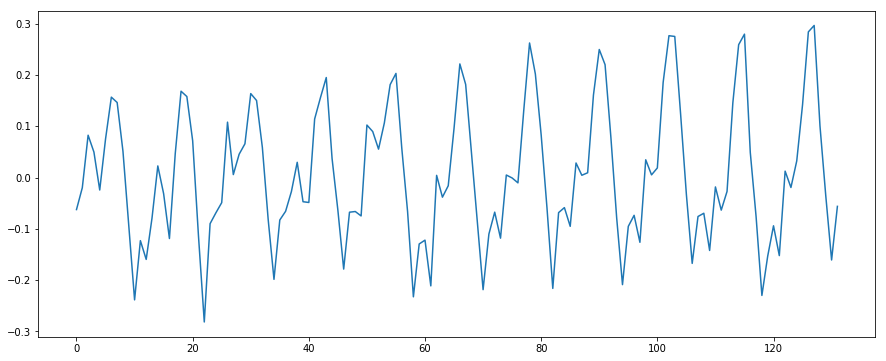

In [51]:
train_set = ts_log.values[:TRAIN_SIZE] - exog_train
plt.plot(train_set)

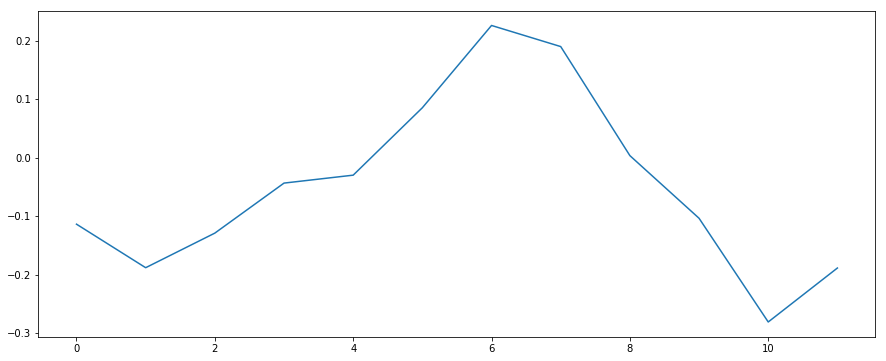

In [52]:
dev_set = ts_log.values[TRAIN_SIZE:] - exog_dev_test[:DEV_SIZE]
plt.plot(dev_set)

开始拟合**SARIMA**模型.

### 寻找差分阶数

根据差分阶数的搜索范围, 依次进行差分和**平稳性检验**, 直到遇到平稳序列为止.

平稳性检验的方法很多, 如常用的**ACF**. 这里使用的是**无参数**的**KPSS检验**方法.

In [53]:
MAX_D = 3

In [54]:
from statsmodels.tsa.stattools import kpss

In [55]:
def stationary_test(ts, kpss_reg_type="c", significance=5):
    try:
        result = kpss(ts, regression=kpss_reg_type)
        p_value = result[1]
        return True if p_value >= significance / 100 else False
    except:
        return False

In [56]:
d = 0

for d in range(MAX_D + 1):
    tmp_ts = np.diff(train_set, d)
    if stationary_test(tmp_ts):
        break
d

D:\Tools\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


0

可以看到这里不需要进行差分, 序列就是平稳的.

在得到差分的阶数后, 立即对时间序列进行差分. 因为后面还要使用季节差分:

- 普通差分之后再进行季节差分阶数的判断
- 普通差分在季节差分之前进行

In [57]:
ts_diff = np.diff(train_set, d)
ts_diff.shape

(132,)

### 季节性检测

当前的时间序列, 是否有季节性, 也是需要通过检验来判断的. 如果没有季节性, 该序列就不需要进行季节差分了. 使用**ACF**和**FFT**两种方法对时间序列进行检验:

- **ACF**: 自相关系数. 如果时间序列有对应长度的季节性, 那个对应`lag`的自相关性应当是显著的, 如果相关系数为0则说明没有相关性, 因此需要判断计算得到的在`lag`处的相关系数是否为0. 这里使用**z检验**. 构造z统计量时, 对应的标准差需要除以$\sqrt{n}$, 即时间序列长度的开方.

- **FFT**: 上面检验的是存在性, FFT检验的是合理性, 即以要检验的数值作为季节周期的长度最合适. 如果时间序列是以当前季节长度为周期, 对应的在序列的**频谱**上应该有表现. 使用FFT由**时域**转为**频域**, 找出频域中能量最大的频率, 再计算这个频率对应的周期, 比较这个周期与我们选定的季节长度是否相等(或者这个周期是否是我们选定的季节长度的因子)

检验季节性其实就是检验给定的季节周期的长度是否合适.

一开始要把季节长度初始化为0, 即没有季节性. 不是所有的时间序列都有季节性, 如果对给定的序列, 在季节长度搜索范围中没有找到合适的季节, 就不能使用季节性.

In [58]:
from scipy.stats import norm

In [59]:
def fft_test(ts, freq):
    fix_len = len(ts) // freq * freq
    tmp_ts = ts[:fix_len]
    fft_res = np.fft.fft(tmp_ts)
    p = np.power(np.abs(fft_res), 2)  # `abs`的作用是对结果中的虚数取模
    tmp_p = p[1:(fix_len // 2)]  # 截半的原因是如果频率超过了一半, 就会有部分位置没有上个(或下个)周期对应的点, 就没有了参考意义
    max_power = np.max(tmp_p)
    max_index = 1 + np.argmax(tmp_p)
    
    try:
        return freq % (fix_len // max_index) == 0
    except ZeroDivisionError:
        return False

In [60]:
def acf_test(ts, freq, significance=5):
    try:
        norm_clim = norm.ppf((2 - significance / 100) / 2) / np.sqrt(len(ts))
        acf_res = acf(ts, unbiased=True, nlags=freq)
        return acf_res[freq] >= norm_clim
    except (TypeError, IndexError):
        return False

In [61]:
def seasonal_detection(ts, recommend_freqs=[3, 6, 12], sigificance=5):
    for frequency in recommend_freqs:
        fft_test_res = fft_test(ts, frequency)
        acf_test_res = acf_test(ts, frequency, sigificance)
        if fft_test_res and acf_test_res:
            return frequency
    return 0

In [62]:
frequency = seasonal_detection(ts_diff)
frequency

12

可以看到准确的检验到了长度为12的季节性, 符合序列图中得到的主观印象.

### 季节性差分

如果上一步得到的季节长度不为0, 则时间序列有季节性, 就需要考虑是否需要进行季节差分. 如果要进行季节差分, 阶数应该为多少.

与普通差分相同, 判断季节性差分阶数的方法也是逐步加大差分的阶数, 直到序列经过差分之后达到季节性平稳为止. 判断季节性平稳的检验方法为**Canova-Hansen检验**.

其原理也是检验**单位根**, 但与**ADF**不同的是, 检验的是**季节单位根**. 对应的原假设为没有季节单位根, 即时间序列是季节平稳的; 备择假设是有季节单位根, 时间序列不是季节平稳的.

In [63]:
from numpy.linalg import lstsq, svd

In [64]:
def seasonal_dummy(ts, frequency):
    """generate seasonal dummy matrix using Fourier series for Canova-Hansen test."""
    n, m = len(ts), frequency
    tt = np.arange(1, n + 1, 1)
    mat = np.zeros([n, 2 * m], dtype=float)
    for i in np.arange(0, m):
        mat[:, 2*i] = np.cos(2.0 * np.pi * (i + 1) * tt / m)
        mat[:, 2*i+1] = np.sin(2.0 * np.pi * (i + 1) * tt / m)
    return mat[:, 0:(m-1)]

In [65]:
def sd_statstics(full_ts, frequency):
    if frequency <= 1:
        return 0
    N = len(full_ts)
    if N <= frequency:
        return 0
    
    frec = np.ones((frequency + 1) // 2, dtype=np.int32)
    l_trunc = int(np.round(np.power(N / 100, 0.25) * frequency))
    r1 = seasonal_dummy(full_ts, frequency)
    r1wInterceptCol = np.column_stack([np.ones(r1.shape[0], dtype=float), r1])
    lstsq_result = lstsq(a=r1wInterceptCol, b=full_ts)
    residual = full_ts - np.matmul(r1wInterceptCol, lstsq_result[0])
    f_hat = np.zeros([N, frequency - 1], dtype=float)
    f_hat_aux = np.zeros([N, frequency - 1], dtype=float)
    for i in np.arange(0, frequency - 1):
        f_hat_aux[:, i] = r1[:, i] * residual
    for i in np.arange(0, N):
        for j in np.arange(0, frequency - 1):
            my_sum = sum(f_hat_aux[0:(i+1), j])
            f_hat[i,j] = my_sum
    
    wnw = np.ones(l_trunc, dtype=float) - np.arange(1, l_trunc + 1, 1) / (l_trunc + 1)
    Ne = f_hat_aux.shape[0]
    omnw = np.zeros([f_hat_aux.shape[1], f_hat_aux.shape[1]], dtype=float)
    for k in range(0, l_trunc):
        omnw = omnw + np.matmul(f_hat_aux.T[:, (k+1):Ne], f_hat_aux[0:(Ne-(k+1)), :]) * float(wnw[k])
    
    cross = np.matmul(f_hat_aux.T, f_hat_aux)
    omnw_plus_transpose = omnw + omnw.T
    omf_hat = (cross + omnw_plus_transpose) / float(Ne)
    
    sq = np.arange(0, frequency - 1, 2)
    frecob = np.zeros(frequency - 1, dtype=int)
    for i in np.arange(0, len(frec)):
        if (frec[i] == 1) & ((i + 1) == int(frequency / 2.0)):
            frecob[sq[i]] = 1
        if (frec[i] == 1) & ((i + 1) < int(frequency / 2.0)):
            frecob[sq[i]] = 1
            frecob[sq[i]+1] = 1
    
    a = frecob.tolist().count(1)
    A = np.zeros([frequency - 1, a], dtype=float)
    j = 0
    for i in np.arange(0, frequency - 1):
        if frecob[i] == 1:
            A[i, j] = 1
            j += 1
    
    aTomfhat = np.matmul(A.T, omf_hat)
    tmp = np.matmul(aTomfhat, A)
    machineDoubleEps = 2.220446e-16
    problems = min(svd(tmp)[1]) < machineDoubleEps
    if problems:
        stL = 0.0
    else:
        solved = np.linalg.solve(tmp, np.eye(tmp.shape[1], dtype=float))
        step1 = np.matmul(solved, A.T)
        step2 = np.matmul(step1, f_hat.T)
        step3 = np.matmul(step2, f_hat)
        step4 = np.matmul(step3, A)
        stL = (1.0 / np.power(N, 2.0)) * sum(np.diag(step4))
    return stL

In [66]:
def ch_test(full_ts, frequency):
    if len(full_ts) < 2 * frequency + 5:
        return False
    crit_values = {2: 0.353, 3: 0.610, 4: 0.846, 5: 1.070, 6: 1.280, 7: 1.490, 8: 1.690, 9: 1.890, 10: 2.100, 11: 2.290,
                   12: 2.490, 13: 2.690, 24: 5.098624, 52: 10.341416, 365: 65.44445}
    ch_stat = sd_statstics(full_ts, frequency)
    if frequency not in crit_values:
        return ch_stat <= 0.269 * np.power(frequency, 0.928)
    return ch_stat <= crit_values[frequency]

In [67]:
def seasonal_diff(ts, order=1, frequency=12, padding=False):
    n = len(ts)
    ts_padding_array = np.array([])
    
    if order == 0:
        return ts
    if n <= frequency * order:
        return ts
    
    tmp1 = ts.copy()
    for _ in range(order):
        tmp_diff = tmp1[frequency:] - tmp1[:-frequency]
        if padding:
            ts_padding_array = np.hstack([ts_padding_array, tmp1[:frequency]])
        tmp1 = tmp_diff.copy()
    if padding:
        tmp_diff = np.hstack([ts_padding_array, tmp_diff])
    return tmp_diff

In [68]:
def cal_seasonal_diff(ts, frequency, max_D=2):
    for D in range(0, max_D + 1):
        if D != 0:
            ts = seasonal_diff(ts, D, frequency=frequency)
        if ch_test(ts, frequency):
            return D
    return D

In [69]:
D = cal_seasonal_diff(ts_diff, frequency)
D

D:\Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


0

可以看到, 这里不需要进行季节性差分, 序列就是平稳的.

In [70]:
ts_seasonal_diff = ts_diff.copy()

### 网格搜索超参数

根据**初始值**, **步长**和**范围**, 逐步搜索`p`, `q`, `P`, `Q`参数, 得到SARIMA模型. 然后使用拟合结果中的**AIC指标**, 选出最优的参数组合.

In [71]:
import sys
from functools import partial
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [72]:
cur_best_aic = sys.maxsize
cur_best_params = []
past_params = set()
b_finished = False

next_params = [[2, 2, 1, 1], [1, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1]] if frequency != 0 else \
              [[2, 2, 0, 0], [1, 1, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0]]

In [73]:
pd_deltas = [-1, 0, 1]
PQ_deltas = [-1, 0, 1] if frequency != 0 else [0 ,0, 0]

In [74]:
maxd, maxp, maxq = 3, 5, 5
maxD, maxP, maxQ = 2, 2, 2

In [75]:
def SARIMA_grid_search(ts, params, freq):
    if params[0] > maxp | params[1] > maxq | params[2] > maxP | params[3] > maxQ:
        return params + [sys.maxsize]
    
    if params[2] + params[3] == 0:
        freq = 0
    
    try:
        model = SARIMAX(ts, order=(params[0], 0, params[1]), seasonal_order=(params[2], 0, params[3], freq), trend="c")
        model_fit = model.fit()
        aic = model_fit.aic
    except ValueError:
        aic = sys.maxsize
    return params + [aic]

In [76]:
while not b_finished:
    model_aic_list = list(map(partial(SARIMA_grid_search, ts_seasonal_diff, freq=frequency), next_params))
    new_best_aic = min(t[4] for t in model_aic_list)
    if new_best_aic == sys.maxsize:
        b_finished = False
    if new_best_aic < cur_best_aic:
        cur_best_aic = new_best_aic
        for t in model_aic_list:
            if t[4] == new_best_aic:
                cur_best_params = t[:4]
    
    for params in next_params:
        past_params.add(tuple(params))
    
    next_params = []
    for params_delta in itertools.product(pd_deltas, pd_deltas, PQ_deltas, PQ_deltas):
        p = max(0, cur_best_params[0] + params_delta[0])
        q = max(0, cur_best_params[1] + params_delta[1])
        P = max(0, cur_best_params[2] + params_delta[2])
        Q = max(0, cur_best_params[3] + params_delta[3])
        next_params.append([p, q, P, Q])
    
    next_params = [params for params, _ in itertools.groupby(next_params) if tuple(params) not in past_params]
    if len(next_params) == 0:
        b_finished = True
    if cur_best_params[2] + cur_best_params[3] + D == 0:
        frequency = 0

D:\Tools\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [77]:
cur_best_aic, cur_best_params

(-449.2183924700097, [1, 0, 1, 0])

In [78]:
p, q, P, Q = cur_best_params

### 使用最优参数拟合SARIMAX模型

In [79]:
train_ts_log = ts_log.values[:TRAIN_SIZE]
dev_ts_log = ts_log.values[TRAIN_SIZE:]
train_ts_log.shape, dev_ts_log.shape, exog_train.shape, exog_dev_test.shape

((132,), (12,), (132,), (36,))

In [80]:
try:
    if P + D + Q == 0:
        if max(p + P, q + Q) == 0:
            q = 1
        model = SARIMAX(train_ts_log, order=(p, d, q), exog=exog_train, trend="c")
    else:
        if max(p + P, q + Q) == 0:
            Q = 1
        model = SARIMAX(train_ts_log, order=(p, d, q), seasonal_order=(P, D, Q, frequency), exog=exog_train, trend="c")
except Exception as e:
    print("Fitting error")
    print(type(e), e)

In [81]:
fit_results = model.fit(method="lbfgs", disp=True)
fit_results

对未来进行预测, 注意要提供未来的**外部变量**.

In [82]:
pred = fit_results.forecast(steps=DEV_SIZE+FCST_SIZE, exog=exog_dev_test[:, None])
pred

array([6.11822085, 6.05741743, 6.20612783, 6.18031997, 6.23327096,
       6.34040499, 6.4780654 , 6.49852104, 6.3298026 , 6.21537185,
       6.1117205 , 6.21679874, 6.24933895, 6.19491225, 6.33107574,
       6.30851643, 6.35760255, 6.45597738, 6.58212147, 6.60166157,
       6.44913565, 6.34598906, 6.25264761, 6.34916085, 6.37969581,
       6.33112828, 6.45591617, 6.43633441, 6.48191931, 6.57233582,
       6.68801045, 6.70672117, 6.56892562, 6.47604408, 6.392081  ,
       6.48080429])

In [83]:
fitted = fit_results.fittedvalues
fitted.shape

(132,)

## 还原预测数组

In [84]:
train_fitted, dev_pred, test_pred = np.exp(fitted), np.exp(pred[:DEV_SIZE]), np.exp(pred[DEV_SIZE:])

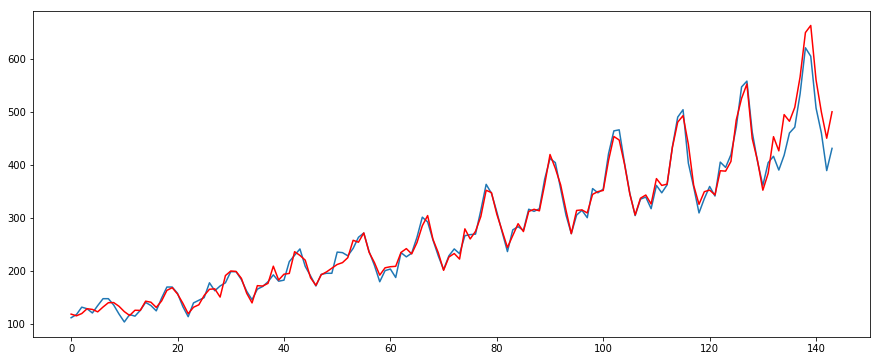

In [85]:
plt.plot(data.values)
plt.plot(np.hstack([train_fitted, dev_pred]), color="red")

使用开发集`dev`对预测结果进行评价, 使用**RMSE**指标.

In [86]:
RMSE = np.sqrt(np.sum(np.power(data.values[-DEV_SIZE:].ravel() - dev_pred, 2)) / DEV_SIZE)
RMSE

48.80289543565935